# Sentiment Analysis using the emotion dataset with 6 emotions
native pytorch

In [1]:
from transformers import AutoTokenizer

chkpt="distilbert-base-uncased"
saveModeldir="saved-model"

tokenizer=AutoTokenizer.from_pretrained(chkpt)

## Get the emotion dataset

In [2]:
from datasets import load_dataset

ds = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/home/john/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


In [3]:
classes={}
for i, mood in enumerate(ds['train'].features['label'].names):
    classes[i]=mood    
classes

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

## Let's see examples of each emotion

In [4]:
mood=0 

for i in range (100):
    if ds['train']['label'][i] ==mood:
        s=ds['train']['text'][i]
        print(f'{classes[mood]}: {s}  ')
        mood+=1
        if mood==6:
            break

sadness: i didnt feel humiliated  
joy: i have been with petronas for years i feel that petronas has performed well and made a huge profit  
love: i feel romantic too  
anger: i think it s the easiest time of year to feel dissatisfied  
fear: i now feel compromised and skeptical of the value of every unit of work i put in  
surprise: i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies  


## Preprocessing the dataset to make it compatible with model's tokenizer

In [5]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_fn(sample):
    return tokenizer(sample['text'], truncation=True)

tokenized_ds = ds.map(tokenize_fn, batched=True)

# remove unwanted columns that miodel is not expecting. renaming column so model can expect it

tokenized_ds=tokenized_ds.remove_columns('text')
tokenized_ds=tokenized_ds.rename_column('label', 'labels')
tokenized_ds
tokenized_ds['train'].column_names

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

['attention_mask', 'input_ids', 'labels']

## Using DataCollator with DataLoader

### DataCp;;ator provides dynamic padding. Wehn combined with dataloader, the amount of padding to use depends on the longest sentence in the current batch. This only works when using GPU, and pytorch

In [6]:
from torch.utils.data import DataLoader

batchSize=128

collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dl = DataLoader(tokenized_ds["train"], shuffle=True, batch_size=batchSize, collate_fn=collator)
eval_dl = DataLoader(tokenized_ds["validation"], batch_size=batchSize, collate_fn=collator)
test_dl= DataLoader(tokenized_ds["test"], batch_size=batchSize, collate_fn=collator)

print(f'train dl has {len(train_dl) }  batches')
print(f'validation dl has {len(eval_dl) }  batches')
print(f'test dl has {len(test_dl) }  batches')

train dl has 125  batches
validation dl has 16  batches
test dl has 16  batches


In [7]:
batch=next(iter(train_dl))
{k: v.shape for k, v in batch.items()}

{'attention_mask': torch.Size([128, 56]),
 'input_ids': torch.Size([128, 56]),
 'labels': torch.Size([128])}

### Notice how the 2nd dimension of the batch changes between batches? that's dynamic padding thanks to the data collator.

## Importing the model

In [8]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(chkpt, num_labels=len(classes), id2label=classes)
model.config.id2label

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [9]:
#try with a batch first to test if model can process a batch
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(1.7629, grad_fn=<NllLossBackward>) torch.Size([128, 6])


## Hyper-Parameters

In [10]:
import math 

lr=1e-4
epochs=5
totalSteps=math.ceil(ds['train'].num_rows/batchSize)*epochs
print(f'training has {totalSteps} total steps')

training has 625 total steps


## importing optimizer and learning rate scheduler

In [11]:
from transformers import AdamW
from transformers import get_scheduler

opt=AdamW(model.parameters(), lr=lr)
scheduler = get_scheduler("cosine",optimizer=opt,num_warmup_steps=0,num_training_steps=totalSteps)

## Setup device to use GPU

In [12]:
import torch 
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 
model.to(device=device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

## Setup training loop

In [13]:
def getAccuracy(outs, batch):
    preds=torch.argmax(outs.logits, dim=1)
    y=torch.sum(preds==batch['labels']).item()
    return y

In [14]:
from tqdm import tqdm 

def train():
    losses=0.
    accs=0
    model.train() 
    torch.set_grad_enabled(True)   

    for batch in tqdm(train_dl):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        losses+=(loss.item() *len(batch['labels']))
        accs+=getAccuracy(outputs, batch)
        loss.backward()        
        opt.step()
        scheduler.step()
        opt.zero_grad()
    return losses/ds['train'].num_rows , accs

In [15]:
from tqdm import tqdm 

def evaluate(ldr):
    losses=0. 
    accs=0
    model.eval()
    torch.set_grad_enabled(False)
    
    for batch in tqdm(ldr):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss.item()
        losses+=(loss*len(batch['labels']))
        accs+=getAccuracy(outputs, batch)    
    return losses/ds['validation'].num_rows , accs

In [16]:
import IPython.display as display 


def showResults(TLosses, TAccs, VLosses, VAccs):
    display.clear_output(wait=True)        
    print('epoch\tTLoss\t\t TAcc\t\t ValLoss\t ValAcc\n')
    i=1
    for tl, ta, vl, va in zip(TLosses, TAccs, VLosses, VAccs) :
        print(f'{i}\t {tl:.3f}\t\t {ta*100.:.3f}%\t {vl:.3f}\t\t {va*100.:.3f}% ')
        i+=1

In [17]:
from tqdm.auto import tqdm

TrainLosses=[]
TrainAccs=[]
valLosses=[]
valAccs=[]

totalTrain=len(ds['train'])
totalVal=len(ds['validation'] )

for epoch in range(epochs):
    print(f'epoch: {epoch+1} / {epochs}  ')
    print('training...')
    loss, accs=train()
    TrainLosses.append(loss)
    acc=accs/totalTrain 
    TrainAccs.append(acc)
    
    #test validation set
    print('evaluating...')
    loss, accs=evaluate(eval_dl)
    acc=accs/totalVal
    valLosses.append(loss)
    valAccs.append(acc)    
    showResults(TrainLosses, TrainAccs, valLosses, valAccs)

epoch	TLoss		 TAcc		 ValLoss	 ValAcc

1	 0.537		 80.612%	 0.165		 93.500% 
2	 0.133		 94.131%	 0.138		 93.350% 
3	 0.090		 95.531%	 0.130		 93.700% 
4	 0.066		 96.844%	 0.136		 93.550% 
5	 0.055		 97.644%	 0.137		 93.600% 


## Let's plot the losses and accuracies

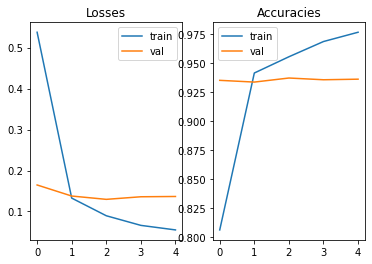

In [18]:
import matplotlib.pyplot as plt 

plt.subplot(1,2,1)
plt.title('Losses')
plt.plot(TrainLosses, label='train')
plt.plot(valLosses,label='val')
plt.legend()
plt.subplot(1,2,2)
plt.title('Accuracies')
plt.plot(TrainAccs, label='train')
plt.plot(valAccs, label='val')
plt.legend()
plt.show()

In [19]:
loss, acc=evaluate(test_dl)
acc=acc/len(ds['test'])
print(f'test accuracy={acc*100.:.3f} %')

  0%|          | 0/16 [00:00<?, ?it/s]

test accuracy=92.850 %


## Save the trained model

In [20]:
model.save_pretrained(saveModeldir)

## Load the model for inference

In [ ]:
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 

In [ ]:
from transformers import AutoModelForSequenceClassification 

model2= AutoModelForSequenceClassification.from_pretrained(saveModeldir)
#model2.config
model2.to(device)

In [ ]:
def getMood(samples):
    input=tokenizer(samples,padding=True, truncation=True, return_tensors="pt" ).to(device)
    out=model2(**input)
    res=torch.argmax(out.logits , dim=1)    
    return res.cpu()

In [ ]:
str1="i am really annoyed"
str2="my heart yearns for her return"
str3="my heart is torn apart"
str4="it's a great sunday today"
str5="i'm left speechless"
str6="i stepped into the unknown"

strs=[str1, str2, str3, str4, str5, str6]

out=getMood(strs)

for i, res in enumerate(out):
    print(f'{strs[i]}: {model2.config.id2label[res.item()]}')